In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '47-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'


import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [5]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 512,
  "EPOCHS": 20,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 3,
  "TTA_STEPS": 15,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB0',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 512,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 20,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 3,
 'TTA_STEPS': 15,
 'WIDTH': 256}

# Load data

In [8]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-c2f318ab381f072971d2adb35fbd1cf6f734c11ee731b63b7915ac3e'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [28]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .6: # @cdeotte's functions
        if p_spatial2 >= .9:
            image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        elif p_spatial2 >= .8:
            image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'])
        elif p_spatial2 >= .7:
            image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'])
        else:
            image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.8)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [29]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 15. * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = 5. * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = 25. * tf.random.normal([1],dtype='float32') 
    width_shift = 25. * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.000298 to 7.27e-06


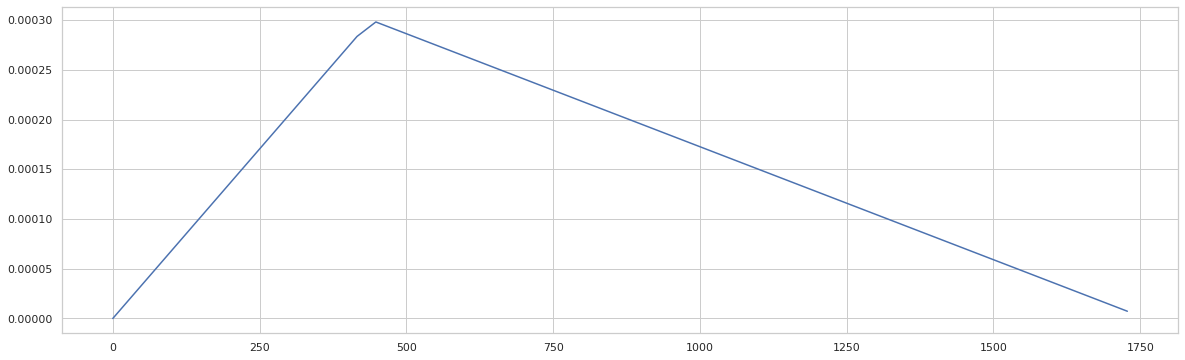

In [24]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 45365 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, 32)]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [31]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)

    # multi-sample dropout
    samples = []
    sample_mask = L.Dense(512, activation='relu')
    for n in range(16): # 16 samples
        sample = L.Dropout(.5)(x)
        sample = sample_mask(sample)
        sample = L.Dense(1, activation='sigmoid', name=f'sample_{n}')(sample)
        samples.append(sample)
    
    output = L.Average(name='output')(samples)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [32]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)

NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                     total_steps=total_steps, warmup_steps=warmup_steps, 
                                                     hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                     lr_max=lr_max, lr_min=lr_min)
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.87.173.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.87.173.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
93/93 - 40s - auc: 0.5732 - loss: 0.5581 - val_auc: 0.5651 - val_loss: 0.3578
Epoch 2/20
93/93 - 25s - auc: 0.8662 - loss: 0.2858 - val_auc: 0.7661 - val_loss: 0.3153
Epoch 3/20
93/93 - 25s - auc: 0.8973 - loss: 0.2663 - val_auc: 0.8815 - val_loss: 0.2768
Epoch 4/20
93/93 - 25s - auc: 0.9169 - loss: 0.2522 - val_auc: 0.9132 - val_loss: 0.2592
Epoch 5/20
93/93 - 25s - auc: 0.9272 - loss: 0.2423 - val_auc: 0.9289 - val_loss: 0.2408
Epoch 6/20
93/93 - 25s - auc: 0.9366 - loss: 0.2345 - val_auc: 0.9435 - val_loss: 0.2269
Epoch 7/20
93/93 - 23s - auc: 0.9453 - loss: 0.2241 - val_auc: 0.9220 - val_loss: 0.2481
Epoch 8/20
93/93 - 23s - auc: 0.9530 - loss: 0.2175 - val_auc: 0.9378 - val_loss: 0.2368
Epoch 9/20
93/93 - 25s - auc: 0.9595 - loss: 0.2093 - val_auc: 0.9462 - val_loss: 0.2207
Epoch 10/20
93/93 - 25s - auc: 0.9663 - loss: 0.2001 - val_auc: 0.9472 - val_loss: 0.2185
Epoch 11/20
93/93 - 24s - auc: 0.9687 - loss: 0.1954 - val_auc: 0.9528 - val_loss: 0.2230
Epoch 12/20
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.87.173.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.87.173.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
93/93 - 40s - auc: 0.5516 - loss: 0.5853 - val_auc: 0.5710 - val_loss: 0.3673
Epoch 2/20
93/93 - 25s - auc: 0.8617 - loss: 0.2866 - val_auc: 0.7714 - val_loss: 0.3200
Epoch 3/20
93/93 - 25s - auc: 0.8987 - loss: 0.2643 - val_auc: 0.8769 - val_loss: 0.2898
Epoch 4/20
93/93 - 25s - auc: 0.9169 - loss: 0.2515 - val_auc: 0.9193 - val_loss: 0.2549
Epoch 5/20
93/93 - 26s - auc: 0.9286 - loss: 0.2417 - val_auc: 0.9271 - val_loss: 0.2435
Epoch 6/20
93/93 - 23s - auc: 0.9370 - loss: 0.2321 - val_auc: 0.9324 - val_loss: 0.2484
Epoch 7/20
93/93 - 30s - auc: 0.9458 - loss: 0.2222 - val_auc: 0.9425 - val_loss: 0.2295
Epoch 8/20
93/93 - 27s - auc: 0.9538 - loss: 0.2154 - val_auc: 0.9497 - val_loss: 0.2255
Epoch 9/20
93/93 - 25s - auc: 0.9600 - loss: 0.2059 - val_auc: 0.9511 - val_loss: 0.2236
Epoch 10/20
93/93 - 25s - auc: 0.9664 - loss: 0.1984 - val_auc: 0.9488 - val_loss: 0.2200
Epoch 11/20
93/93 - 25s - auc: 0.9716 - loss: 0.1927 - val_auc: 0.9545 - val_loss: 0.2171
Epoch 12/20
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.87.173.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.87.173.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
97/97 - 39s - auc: 0.5888 - loss: 0.5364 - val_auc: 0.6443 - val_loss: 0.3532
Epoch 2/20
97/97 - 26s - auc: 0.8752 - loss: 0.2791 - val_auc: 0.7753 - val_loss: 0.3305
Epoch 3/20
97/97 - 26s - auc: 0.9049 - loss: 0.2603 - val_auc: 0.8749 - val_loss: 0.2886
Epoch 4/20
97/97 - 26s - auc: 0.9185 - loss: 0.2473 - val_auc: 0.9184 - val_loss: 0.2677
Epoch 5/20
97/97 - 26s - auc: 0.9313 - loss: 0.2393 - val_auc: 0.9293 - val_loss: 0.2499
Epoch 6/20
97/97 - 26s - auc: 0.9423 - loss: 0.2285 - val_auc: 0.9291 - val_loss: 0.2416
Epoch 7/20
97/97 - 26s - auc: 0.9494 - loss: 0.2195 - val_auc: 0.9372 - val_loss: 0.2396
Epoch 8/20
97/97 - 26s - auc: 0.9583 - loss: 0.2106 - val_auc: 0.9429 - val_loss: 0.2332
Epoch 9/20
97/97 - 24s - auc: 0.9638 - loss: 0.2031 - val_auc: 0.9350 - val_loss: 0.2343
Epoch 10/20
97/97 - 26s - auc: 0.9682 - loss: 0.1962 - val_auc: 0.9415 - val_loss: 0.2302
Epoch 11/20
97/97 - 25s - auc: 0.9740 - loss: 0.1883 - val_auc: 0.9433 - val_loss: 0.2260
Epoch 12/20
97/97 -

## Model loss graph

Fold: 1


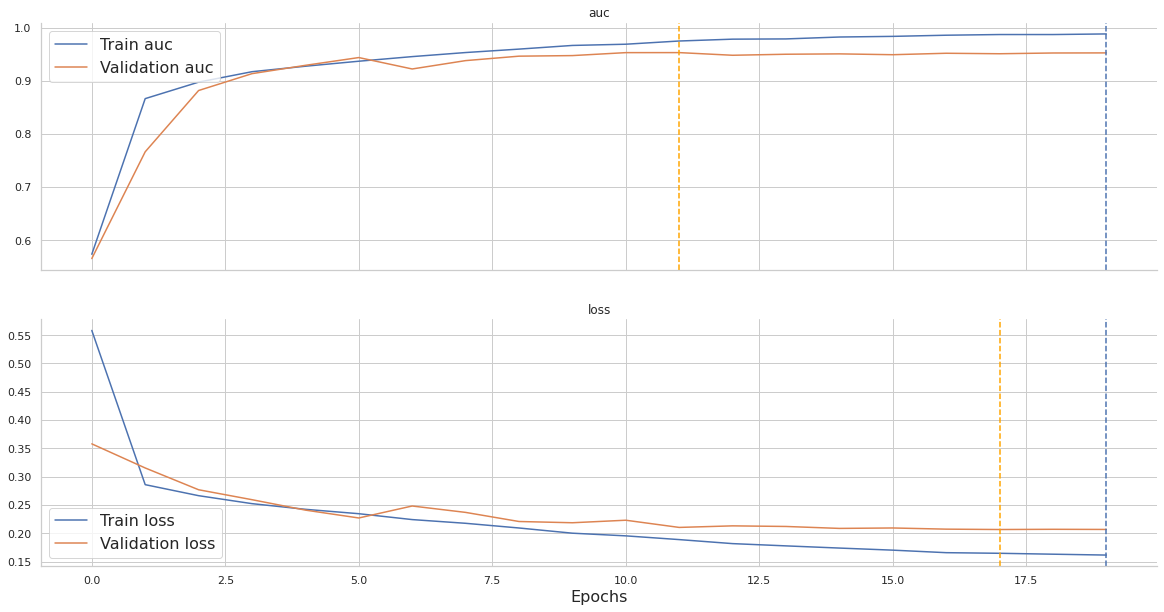

Fold: 2


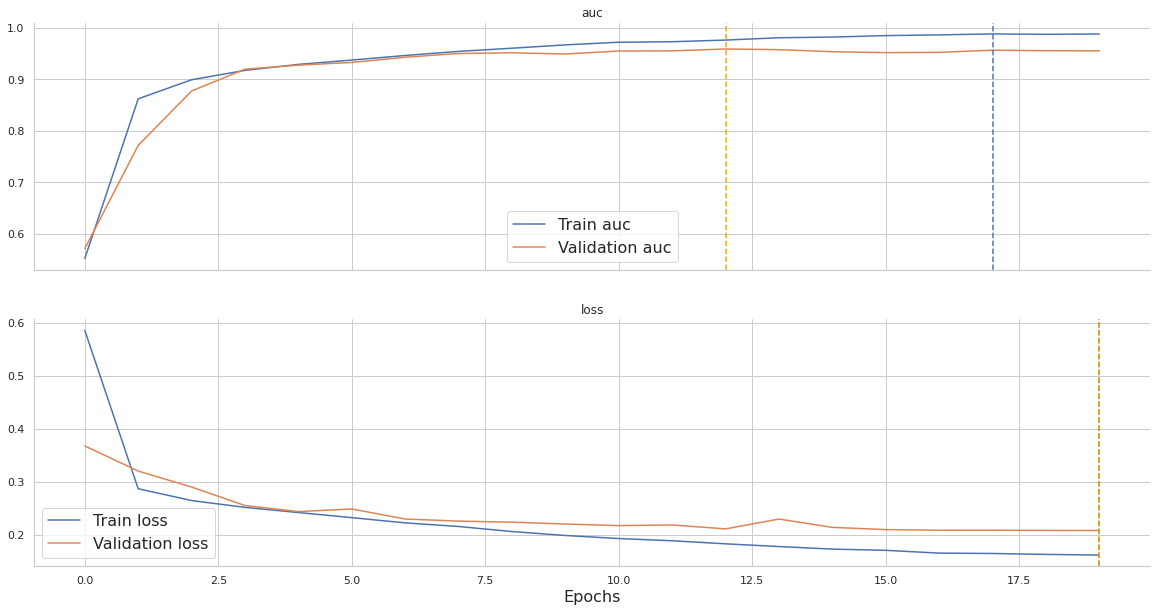

Fold: 3


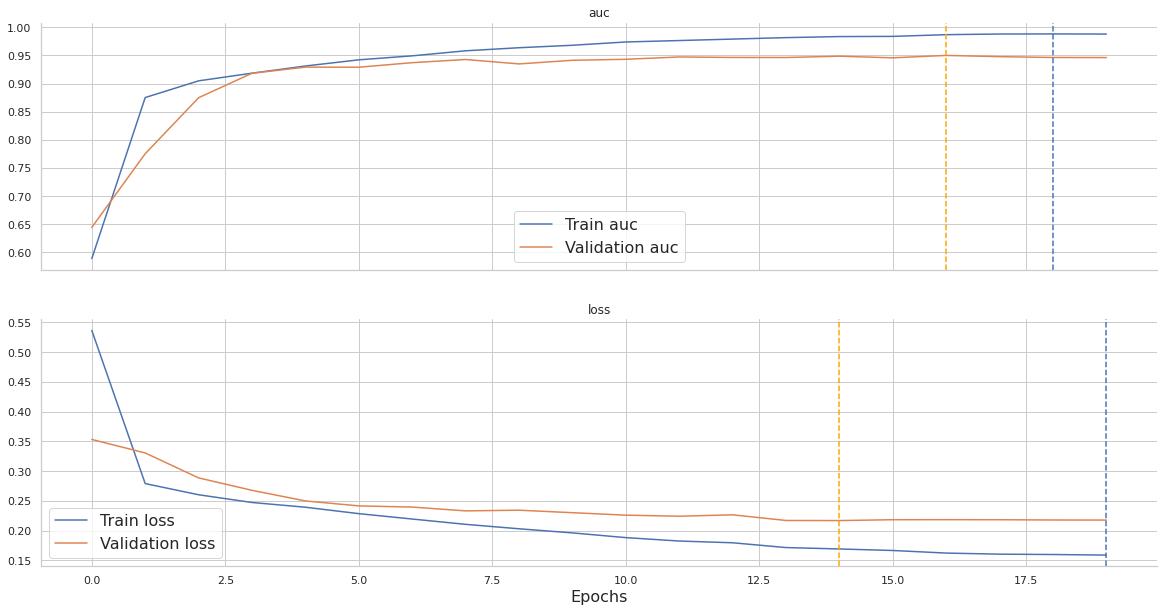

In [33]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

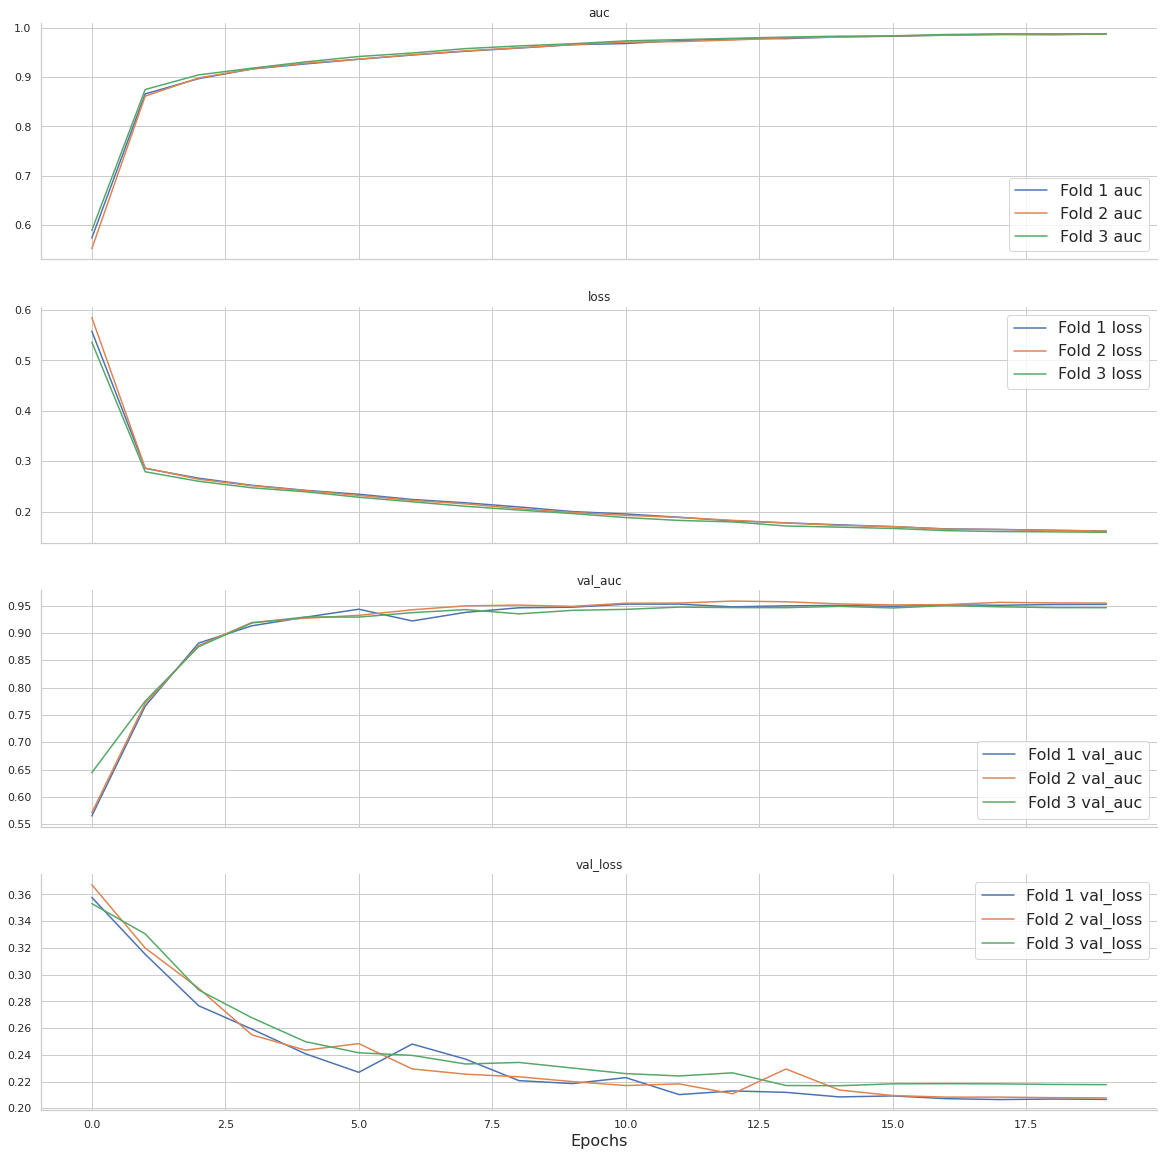

In [34]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [35]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.982427,0.869821,0.112606,0.979385,0.869877,0.984523,0.875027,0.983373,0.864558
Accuracy,0.993905,0.980305,0.013600,0.993783,0.981026,0.993735,0.980560,0.994196,0.979329
Precision,0.922174,0.401503,0.520671,0.933518,0.352113,0.913649,0.426471,0.919355,0.425926
Recall,0.714705,0.224368,0.490337,0.706499,0.233645,0.709957,0.237705,0.727660,0.201754
F1-score,0.805224,0.286657,0.518567,0.804296,0.280899,0.799026,0.305263,0.812352,0.273810
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


# Model evaluation by Subset

In [36]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.982427,0.869821,0.112606,0.979385,0.869877,0.984523,0.875027,0.983373,0.864558
male,0.986101,0.874805,0.111296,0.985536,0.876057,0.984581,0.896431,0.988187,0.851929
female,0.976783,0.858237,0.118547,0.969320,0.856769,0.984249,0.835713,0.976782,0.882227
head/neck,0.994239,0.877275,0.116964,0.990150,0.954069,0.996879,0.853839,0.995688,0.823916
upper extremity,0.980065,0.873071,0.106994,0.972737,0.862484,0.989740,0.852997,0.977717,0.903731
lower extremity,0.973636,0.792652,0.180983,0.970264,0.827363,0.975160,0.749444,0.975483,0.801149
torso,0.984895,0.909420,0.075475,0.982944,0.867259,0.985753,0.937972,0.985987,0.923029
0 <= age < 26,0.957347,0.783336,0.174010,0.944185,0.870652,0.974761,0.724727,0.953093,0.754630
26 <= age < 40,0.976431,0.827313,0.149118,0.982554,0.706153,0.975074,0.854976,0.971666,0.920811


# Model evaluation (best)

In [37]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.981037,0.873423,0.107613,0.978912,0.872964,0.984583,0.874821,0.979615,0.872486
Accuracy,0.993697,0.980100,0.013597,0.993783,0.981915,0.993773,0.980412,0.993535,0.977974
Precision,0.921093,0.390184,0.530909,0.943343,0.377049,0.911602,0.422535,0.908333,0.370968
Recall,0.702715,0.220870,0.481845,0.698113,0.214953,0.714286,0.245902,0.695745,0.201754
F1-score,0.797111,0.282018,0.515093,0.802410,0.273810,0.800971,0.310881,0.787952,0.261364
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.981037,0.873423,0.107613,0.978912,0.872964,0.984583,0.874821,0.979615,0.872486
male,0.984819,0.880303,0.104516,0.985213,0.880283,0.984719,0.896123,0.984526,0.864503
female,0.975236,0.857282,0.117954,0.968660,0.857232,0.984196,0.835611,0.972852,0.879004
head/neck,0.994338,0.879048,0.115290,0.990386,0.958098,0.996915,0.852033,0.995712,0.827012
upper extremity,0.978886,0.880442,0.098444,0.972196,0.873686,0.989670,0.853387,0.974793,0.914253
lower extremity,0.971422,0.797397,0.174025,0.970146,0.834234,0.975384,0.749251,0.968737,0.808707
torso,0.983310,0.907811,0.075499,0.982286,0.865330,0.985720,0.937695,0.981923,0.920406
0 <= age < 26,0.954689,0.796736,0.157953,0.941506,0.872283,0.974943,0.723019,0.947619,0.794907
26 <= age < 40,0.974492,0.824904,0.149588,0.981803,0.695252,0.974814,0.856240,0.966859,0.923220


# Confusion matrix

Fold: 1


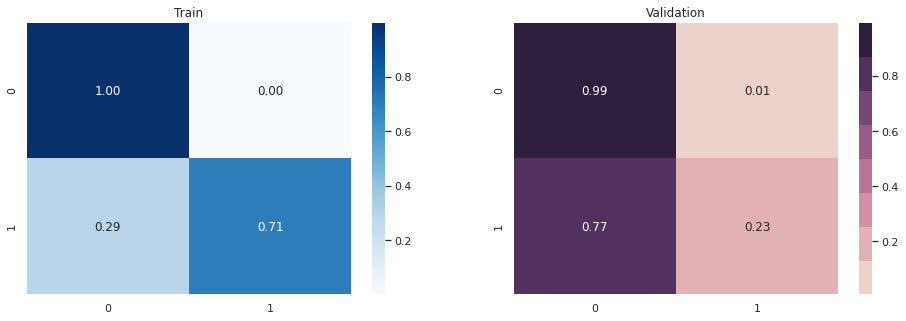

Fold: 2


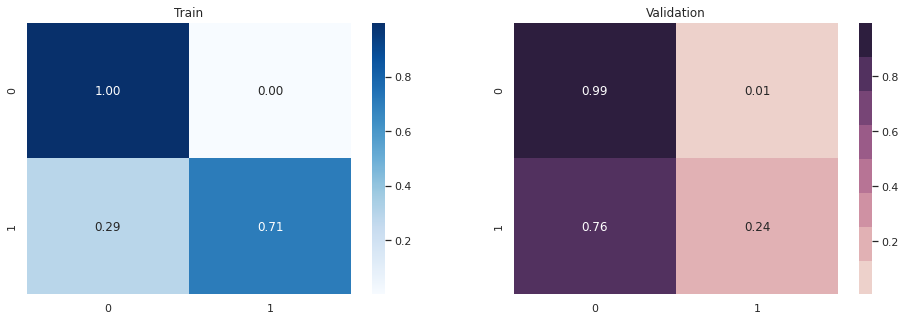

Fold: 3


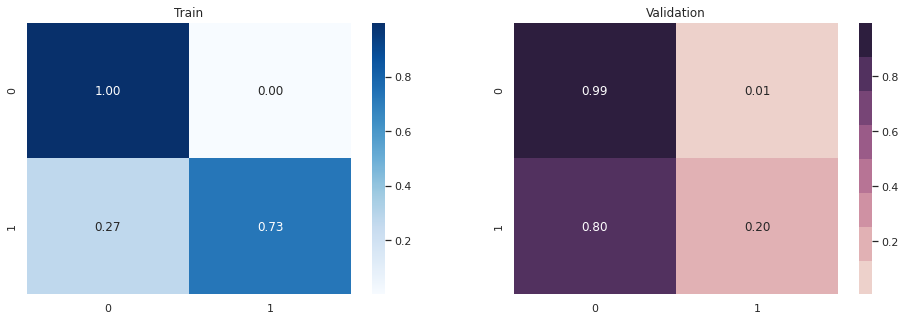

In [38]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [39]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 190
Train positive correct predictions: 187
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.018251,0.030888,0.031311,0.029056
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.016622,0.028989,0.026824,0.027295
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.018316,0.030516,0.030885,0.030179
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.017117,0.027411,0.030299,0.027875
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.015910,0.024638,0.026702,0.028211
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.025441,0.025483,0.074830,0.026891
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.015518,0.026288,0.024524,0.026778
7,ISIC_0075663,female,35.0,torso,unknown,0,0.016919,0.027121,0.026992,0.030482
8,ISIC_0075914,male,30.0,torso,unknown,0,0.016575,0.026000,0.028155,0.028719
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.016795,0.027795,0.027558,0.028623


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.016837,0.024679,0.030892,0.028613
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.274300,0.643526,0.030824,0.697149
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.355676,0.699034,0.139003,0.940344
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.413045,0.856875,0.569207,0.639146
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.538029,0.866790,0.932956,0.890398
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.554649,0.851210,0.965272,0.956761
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.404236,0.220943,0.932944,0.867292
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.393640,0.682985,0.380450,0.904763
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.345814,0.063860,0.827905,0.837303
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.199345,0.908535,0.058760,0.029430


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.538029,0.866790,0.932956,0.890398
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.554649,0.851210,0.965272,0.956761
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.577365,0.975737,0.935196,0.975891
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.500090,0.570771,0.963254,0.966425
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.585788,0.986280,0.975829,0.966833
1335,ISIC_0504165,female,60.0,lower extremity,melanoma,1,0.569394,0.916941,0.968522,0.961506
1423,ISIC_0528044,male,65.0,torso,melanoma,1,0.549253,0.848994,0.964544,0.932729
1435,ISIC_0533122,male,75.0,lower extremity,melanoma,1,0.567744,0.963986,0.915882,0.958853
1742,ISIC_0624498,female,80.0,torso,melanoma,1,0.584400,0.970989,0.973194,0.977816
1790,ISIC_0639769,male,65.0,head/neck,melanoma,1,0.591600,0.990634,0.983564,0.983801


# Visualize test predictions

In [40]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 121|10861
Test predictions (last) 124|10858
Test predictions (tta) 117|10865
Test predictions (last tta) 123|10859
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.026718,0.025926,0.026392,0.025627
1,ISIC_0052349,male,40.0,lower extremity,0.027064,0.026230,0.028247,0.027330
2,ISIC_0058510,female,55.0,torso,0.026460,0.026143,0.025609,0.024940
3,ISIC_0073313,female,50.0,torso,0.025209,0.024938,0.026007,0.025398
4,ISIC_0073502,female,45.0,lower extremity,0.028084,0.026940,0.027479,0.026820
5,ISIC_0074618,male,50.0,lower extremity,0.029756,0.028233,0.030529,0.030170
6,ISIC_0076801,male,45.0,upper extremity,0.031205,0.028949,0.028089,0.027362
7,ISIC_0077586,male,50.0,lower extremity,0.095100,0.070552,0.044317,0.042711
8,ISIC_0082004,female,45.0,torso,0.027304,0.026749,0.028205,0.027384
9,ISIC_0082785,male,65.0,lower extremity,0.024681,0.023836,0.027172,0.025775


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.588835,0.690472,0.777609,0.865109
102,ISIC_0208233,female,60.0,lower extremity,0.936779,0.935201,0.779316,0.827670
255,ISIC_0351156,male,40.0,head/neck,0.875481,0.773042,0.905010,0.897995
296,ISIC_0391046,male,85.0,torso,0.604252,0.676376,0.587714,0.666661
352,ISIC_0442293,male,50.0,torso,0.540342,0.573133,0.166569,0.174937
403,ISIC_0481105,male,80.0,torso,0.952164,0.961275,0.881918,0.894234
453,ISIC_0524466,female,30.0,head/neck,0.556083,0.442152,0.564242,0.452237
471,ISIC_0539432,female,45.0,lower extremity,0.976988,0.978781,0.967651,0.970595
552,ISIC_0606244,male,70.0,torso,0.954509,0.957116,0.846964,0.888699
596,ISIC_0637104,female,80.0,torso,0.787250,0.835540,0.662616,0.613653


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.588835,0.690472,0.777609,0.865109
102,ISIC_0208233,female,60.0,lower extremity,0.936779,0.935201,0.779316,0.827670
255,ISIC_0351156,male,40.0,head/neck,0.875481,0.773042,0.905010,0.897995
296,ISIC_0391046,male,85.0,torso,0.604252,0.676376,0.587714,0.666661
352,ISIC_0442293,male,50.0,torso,0.540342,0.573133,0.166569,0.174937
403,ISIC_0481105,male,80.0,torso,0.952164,0.961275,0.881918,0.894234
471,ISIC_0539432,female,45.0,lower extremity,0.976988,0.978781,0.967651,0.970595
552,ISIC_0606244,male,70.0,torso,0.954509,0.957116,0.846964,0.888699
596,ISIC_0637104,female,80.0,torso,0.787250,0.835540,0.662616,0.613653
727,ISIC_0740997,male,40.0,torso,0.505349,0.524141,0.253726,0.239830


# Test set predictions

In [41]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.026718,0.025926,0.026322,0.026392,0.025627,0.026009
1,ISIC_0052349,0.027064,0.026230,0.026647,0.028247,0.027330,0.027789
2,ISIC_0058510,0.026460,0.026143,0.026302,0.025609,0.024940,0.025275
3,ISIC_0073313,0.025209,0.024938,0.025074,0.026007,0.025398,0.025703
4,ISIC_0073502,0.028084,0.026940,0.027512,0.027479,0.026820,0.027149
5,ISIC_0074618,0.029756,0.028233,0.028994,0.030529,0.030170,0.030350
6,ISIC_0076801,0.031205,0.028949,0.030077,0.028089,0.027362,0.027726
7,ISIC_0077586,0.095100,0.070552,0.082826,0.044317,0.042711,0.043514
8,ISIC_0082004,0.027304,0.026749,0.027026,0.028205,0.027384,0.027795
9,ISIC_0082785,0.024681,0.023836,0.024259,0.027172,0.025775,0.026474


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.048304,0.047160,0.047732,0.048521,0.047943,0.048232
std,0.090068,0.091319,0.090585,0.085923,0.088007,0.086821
min,0.021646,0.020722,0.021184,0.023001,0.023037,0.023033
25%,0.027230,0.026499,0.026862,0.027417,0.026803,0.027114
50%,0.029309,0.028410,0.028846,0.029771,0.028994,0.029390
75%,0.033929,0.032293,0.033136,0.035116,0.033609,0.034427
max,0.981640,0.983236,0.982438,0.983032,0.984918,0.983975
